# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [1]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
!mkdir data

In [5]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31314    0 31314    0     0  97264      0 --:--:-- --:--:-- --:--:-- 97248


In [6]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70173    0 70173    0     0   204k      0 --:--:-- --:--:-- --:--:--  205k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [42]:
!pip install langchain langgraph ragas


  Obtaining dependency information for ragas from https://files.pythonhosted.org/packages/b6/1f/1087efbd0d0723ef8212aba2dfd035bdbcef6698623b29e6f724ad8cdcf9/ragas-0.2.13-py3-none-any.whl.metadata
  Obtaining dependency information for diskcache>=5.6.3 from https://files.pythonhosted.org/packages/3f/27/4570e78fc0bf5ea0ca45eb1de3818a23787af9b390c0b0a0033a1b8236f9/diskcache-5.6.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.3/178.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 7.4 MB/s eta 0:00:00


### EVOL

In [ ]:
from langgraph.graph import StateGraph
from pydantic import BaseModel
from typing import List, Dict
import json
import asyncio
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import re


generator_llm = ChatOpenAI(model="gpt-4o")
# Text Splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
rag_documents = text_splitter.split_documents(docs)

# State Graph Definition
class EvolState(BaseModel):
    evolved_questions: List[Dict] = []
    evolved_answers: List[Dict] = []
    evolved_contexts: List[Dict] = []

# Define a prompt template
evolution_prompt = PromptTemplate.from_template(
    "Take the given question: '{question}', and evolve it using the Evol Instruct method. "
    "Return the response strictly as a JSON object with the following keys: 'question', 'evolution_type', and 'id'.\n"
    "Example output: {{\"question\": \"How will AI change surgery techniques?\", \"evolution_type\": \"Complex\", \"id\": \"12345\"}}"
)


answer_prompt = PromptTemplate.from_template(
    "Provide an answer for the question: {question}."
)

context_prompt = PromptTemplate.from_template(
    "Retrieve the most relevant context from the documents for the question: {question}."
)

# Create LLM Chains
evolution_chain = LLMChain(llm=generator_llm, prompt=evolution_prompt)
answer_chain = LLMChain(llm=generator_llm, prompt=answer_prompt)
context_chain = LLMChain(llm=generator_llm, prompt=context_prompt)

# Async Functions to Process Data
async def evolve_question(state: EvolState) -> Dict:
    MAX_EVOLUTIONS = 3

    # Count how many times evolution has occurred
    evolution_count = len(state.evolved_questions)

    if evolution_count >= MAX_EVOLUTIONS:
        print("\nReached max evolutions. Moving to answer generation.\n")
        return {}  # Stop evolving and move to the next step

    # Use the last evolved question, or start with a default
    if not state.evolved_questions:
        initial_question = "How will AI impact healthcare in the next 10 years?"
    else:
        initial_question = state.evolved_questions[-1]["question"]

    response = await evolution_chain.arun({"question": initial_question})

    # Debugging: Print the raw response before parsing
    print(f"\nEvolution {evolution_count + 1} - Raw response from LLM:", response)

    # Remove Markdown-style JSON formatting if present
    response_cleaned = re.sub(r"```json\n(.*?)\n```", r"\1", response, flags=re.DOTALL).strip()

    try:
        evolved_question = json.loads(response_cleaned)  # Ensure valid JSON
    except json.JSONDecodeError as e:
        print("Error decoding JSON. Cleaned response:", response_cleaned)
        raise e

    return {"evolved_questions": state.evolved_questions + [evolved_question]}


# Initialize LangGraph
graph = StateGraph(EvolState)

# Define Nodes (Add these back)
graph.add_node("evolve_question", evolve_question)
graph.add_node("generate_answer", generate_answer)
graph.add_node("retrieve_context", retrieve_context)

# Define Edges (After nodes are defined)
graph.add_edge("evolve_question", "evolve_question")  # Recursive connection
graph.add_edge("evolve_question", "generate_answer")  # When stopping evolution, move forward
graph.add_edge("generate_answer", "retrieve_context")

# Define Entry Point
graph.set_entry_point("evolve_question")

# Compile the LangGraph pipeline
evol_pipeline = graph.compile()

# Execute the graph
async def run_pipeline():
    initial_state = EvolState()
    final_state = None  # Initialize a variable to store the last state update

    async for state_update in evol_pipeline.astream(initial_state, {"recursion_limit": 100}):
        if "__end__" not in state_update:
            print(state_update)  # Print intermediate updates
            print("---")
            final_state = state_update  # Store the latest state update

    # Ensure we have a valid final state before saving
    if final_state:
        # Convert AddableUpdatesDict to a normal dictionary
        final_state_dict = dict(final_state)

        # Save Output
        with open("evolved_data.json", "w") as f:
            json.dump(
                {
                    "evolved_questions": final_state_dict.get("evolved_questions", []),
                    "evolved_answers": final_state_dict.get("evolved_answers", []),
                    "evolved_contexts": final_state_dict.get("evolved_contexts", []),
                },
                f,
                indent=4
            )

        # Extract and print evolved questions as a list
        evolved_questions_list = [q["question"] for q in final_state_dict.get("evolved_questions", [])]
        print("\nList of Generated Questions:")
        print(evolved_questions_list)

        # Extract and print evolved answers as a list
        evolved_answers_list = [a["answer"] for a in final_state_dict.get("evolved_answers", [])]
        print("\nList of Generated Answers:")
        print(evolved_answers_list)

        print("\nGenerated Contexts:", final_state_dict.get("evolved_contexts", []))
    else:
        print("No final state received from the stream.")


# Run the async function properly inside Jupyter
await run_pipeline()

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

##### Continue code from the book

In [8]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [9]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [10]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 73)

We can save and load our knowledge graphs as follows.

In [11]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 73)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [12]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [13]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

(SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5): Generates Specific, single-hop queries that directly align with the provided knowledge chunks.

(MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25): Generates more abstract or generalized multi-hop queries that require reasoning accross multiple knowledge chunks.

(MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25): Generates speficif, multi-hop queries that require chaining multiple retrieval steps to arrive at an answer.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [14]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,How does Meta's Llama 3.2 model demonstrate ad...,[Prompt driven app generation is a commodity a...,"Meta’s Llama 3.2 models, particularly the 1B a...",single_hop_specifc_query_synthesizer
1,What are the cost advantages of using GPT-4o c...,"[gets you OpenAI’s most expensive model, o1. G...",GPT-4o is significantly cheaper than other mod...,single_hop_specifc_query_synthesizer
2,What are Claude Artifacts and how have they im...,[your camera feed with the model and talk abou...,Claude Artifacts is a feature released by Anth...,single_hop_specifc_query_synthesizer
3,What insights did Malte Ubl from Vercel share ...,[“agents” as dependent on AGI itself. A model ...,Malte Ubl from Vercel shared that when @v0 fir...,single_hop_specifc_query_synthesizer
4,Wht iz Amazon doin in terms of datacenter expa...,[day after that. DeepSeek v3 is a huge 685B pa...,"Amazon, along with companies like Google, Meta...",single_hop_specifc_query_synthesizer
5,How do the ethics of training data impact the ...,[<1-hop>\n\nCode may be the best application T...,The ethics of training data significantly impa...,multi_hop_abstract_query_synthesizer
6,What are the ethical concerns surrounding the ...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns surrounding the training ...,multi_hop_abstract_query_synthesizer
7,How do the challenges of understanding and con...,[<1-hop>\n\nCode may be the best application T...,The challenges of understanding and controllin...,multi_hop_abstract_query_synthesizer
8,What are the challenges and potential solution...,[<1-hop>\n\nneeds guidance. Those of us who un...,The gullibility of ChatGPT and other LLMs is a...,multi_hop_specific_query_synthesizer
9,What are the challenges and ethical concerns a...,[<1-hop>\n\neasy to follow. The rest of the do...,The development and usage of Large Language Mo...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [15]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What are the notable features of Google's Gemi...,[Prompt driven app generation is a commodity a...,"Google's Gemini 1.5 Pro, released in February,...",single_hop_specifc_query_synthesizer
1,what be the deal with Mistral and all these ne...,"[gets you OpenAI’s most expensive model, o1. G...","In 2024, Mistral released their Pixtral 12B mo...",single_hop_specifc_query_synthesizer
2,what chatgpt do now with camera feed and how i...,[your camera feed with the model and talk abou...,ChatGPT now has the ability to integrate with ...,single_hop_specifc_query_synthesizer
3,Wht is the role of Hugging Face in the develop...,[“agents” as dependent on AGI itself. A model ...,"Hugging Face hosts more than 1,000 models in t...",single_hop_specifc_query_synthesizer
4,How have advancements in LLM efficiency impact...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in LLM efficiency have significan...,multi_hop_abstract_query_synthesizer
5,What are the main criticisms and challenges as...,[<1-hop>\n\nPrompt driven app generation is a ...,The main criticisms and challenges associated ...,multi_hop_abstract_query_synthesizer
6,How have advancements in AI model efficiency a...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in AI model efficiency and pricin...,multi_hop_abstract_query_synthesizer
7,How do the challenges in evaluating Large Lang...,[<1-hop>\n\nPrompt driven app generation is a ...,The challenges in evaluating Large Language Mo...,multi_hop_abstract_query_synthesizer
8,What role did Claude play in the development o...,[<1-hop>\n\nneeds guidance. Those of us who un...,"In 2024, Claude was involved in various LLM ap...",multi_hop_specific_query_synthesizer
9,How has Anthropic's approach to model evaluati...,[<1-hop>\n\ngets you OpenAI’s most expensive m...,"Anthropic's approach to model evaluation, as h...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [17]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [18]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [19]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [21]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [22]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [23]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [24]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [26]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [27]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents refer to AI systems that are expected to act on behalf of users, but the term is vague and lacks a clear definition. Some view AI agents as things that go and act on behalf of a person, similar to a travel agent, while others think of large language models (LLMs) that utilize tools to solve problems. The concept is still developing, and there is skepticism about their utility due to challenges such as gullibility.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [28]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [29]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: Question-Answer correctness and relevance
- `labeled_helpfulness_evaluator`:Helpfulness of the response compared to a reference answer
- `dope_or_nope_evaluator`: "Dopeness" or overall response quality (coolness factor)

## LangSmith Evaluation

In [30]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'slight-idea-80' at:
https://smith.langchain.com/o/444579ff-06e3-4776-bce0-6c12b44e5fa1/datasets/7c9619b8-6c29-482f-bb47-7c60807a845b/compare?selectedSessions=f5e4c2b2-7c19-4e84-904e-c0aa7c61b961




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How has the development of Claude 3 and other ...,I don't know.,None,The development of Claude 3 and other multi-mo...,0,0,0,1.294400,b2240526-907a-4678-a841-bd3023efbe3d,c9abd55a-5868-41cd-96e9-03cf819d2d7e
1,What are some key advancements in Large Langua...,Key advancements in Large Language Models (LLM...,None,"In 2024, Simon Willison highlighted several ke...",1,1,1,3.156233,df35c442-01e0-4086-8b97-1c0daa5babef,fd4358bb-621f-48f1-a139-9b85bbdfeacb
2,How did the developments in 2024 lead to the b...,The developments in 2024 led to the breaking o...,None,"In 2024, significant advancements in the field...",1,1,1,2.919968,38ac5e60-a2d8-4a9a-b3cf-3d9bf73b07b7,516ef5ae-1c3d-4b05-a227-efb4bc3e2501
3,How does the development of Claude and the imp...,I don't know.,None,"The development of Claude, as highlighted by A...",0,0,0,1.090003,703e9504-dc0c-4c46-89ad-31dd6fe4235f,11380ffc-4c9c-47c5-bb18-97b807d5e0d5
4,How does the black box nature of Large Languag...,I don't know.,None,The black box nature of Large Language Models ...,0,0,0,0.880171,ec28f58d-9209-4111-89f0-92e31aa156cb,921cd964-046c-46db-aca7-61b59c173302
5,How does the use of unlicensed training data i...,I don't know.,None,The use of unlicensed training data in the dev...,0,0,0,0.568890,9218f3c8-8e14-49f6-93f2-f0606fcf6e6d,50532fbe-1c3a-48c8-b0d6-67a16f1a2431
6,What role does OpenAI play in the development ...,I don't know.,None,OpenAI was one of the first organizations to r...,0,0,0,0.769663,994a34e1-be52-4055-93bf-f628e9b00de2,e41ea802-6e27-4922-9a00-9b8e7a76aab7
7,What advancements in AI-generated content and ...,Recent discussions about Large Language Models...,None,Recent discussions about Large Language Models...,0,0,1,3.216158,6481e16a-8d7e-416a-9518-253e9bf7585f,700f8074-b30f-47c3-ae13-400d402f4766
8,"what vercel do with prompts and evals, how the...","Based on the context, it appears that Vercel's...",None,Vercel's Malte Ubl mentioned that when @v0 fir...,1,0,0,2.125947,fd34d20e-c7cd-49b6-8529-9fd39663493d,8fb55675-ae8a-435a-b21f-aea48de4cf2b
9,What significant feature did Anthropic introdu...,Anthropic introduced the significant feature o...,None,"Anthropic introduced Claude Artifacts, a groun...",1,1,1,1.615585,3634106a-cbca-4bf4-8b19-ad9c135663cc,10703ce5-8285-4b20-822e-dddb6ba4d2da


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [31]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [32]:
rag_documents = docs

In [33]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

- More context per chunk, reducing the chances of missing key information.
- Improved coherence, as entire sections of text are preserved.

In [35]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

- Switching to a different embedding model affects how well your application retrieves relevant information.
- text-embedding-3-large is more powerful than previous models (text-embedding-ada-002) and captures deeper semantic relationships.

- Impact: Better understanding of user queries → More accurate document retrieval.

In [36]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [37]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [38]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [39]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

"Agents are a super vague concept in the AI world. Some folks think of them as systems that act on your behalf, kind of like a travel agent. Others picture LLMs that use tools to solve problems. But the term has no clear definition, making it confusing. In short, it's a lot of buzz but not much action—still waiting for those dreams to really take flight!"

Finally, we can evaluate the new chain on the same test set!

In [40]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'crazy-ornament-63' at:
https://smith.langchain.com/o/444579ff-06e3-4776-bce0-6c12b44e5fa1/datasets/7c9619b8-6c29-482f-bb47-7c60807a845b/compare?selectedSessions=1cd08591-29f6-497a-a263-da571ff5fc6e




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How has the development of Claude 3 and other ...,I don't know.,None,The development of Claude 3 and other multi-mo...,0,0,0,1.037710,b2240526-907a-4678-a841-bd3023efbe3d,9e9d1574-3d40-402f-ade3-42b00d1e62fd
1,What are some key advancements in Large Langua...,"Yo, check it out! Simon Willison dropped some ...",None,"In 2024, Simon Willison highlighted several ke...",1,1,1,3.553887,df35c442-01e0-4086-8b97-1c0daa5babef,44c97150-383a-4a4e-9e83-c51226896152
2,How did the developments in 2024 lead to the b...,"Yo, check it! In 2024, the game totally change...",None,"In 2024, significant advancements in the field...",1,0,1,3.775226,38ac5e60-a2d8-4a9a-b3cf-3d9bf73b07b7,3ad1ac76-351b-4d7d-8b4f-903d20ab4b0b
3,How does the development of Claude and the imp...,"Yo, when it comes to Claude, it’s like a risin...",None,"The development of Claude, as highlighted by A...",1,0,1,4.668752,703e9504-dc0c-4c46-89ad-31dd6fe4235f,2ca72ddc-7310-4601-898e-a7a340e23599
4,How does the black box nature of Large Languag...,"Yo, the whole black box vibe of Large Language...",None,The black box nature of Large Language Models ...,1,0,1,3.100362,ec28f58d-9209-4111-89f0-92e31aa156cb,c3ace97a-b607-49a9-8eca-309064f94577
5,How does the use of unlicensed training data i...,"Yo, the use of unlicensed training data in the...",None,The use of unlicensed training data in the dev...,1,1,1,3.046007,9218f3c8-8e14-49f6-93f2-f0606fcf6e6d,cbd2742e-009a-4755-a755-269db35087d3
6,What role does OpenAI play in the development ...,OpenAI is a key player in developing Large Lan...,None,OpenAI was one of the first organizations to r...,1,1,1,3.638780,994a34e1-be52-4055-93bf-f628e9b00de2,3f109b28-1d6b-4092-88ad-c108854d5a81
7,What advancements in AI-generated content and ...,"Yo, the buzz about AI and LLMs is real! People...",None,Recent discussions about Large Language Models...,0,0,1,3.311051,6481e16a-8d7e-416a-9518-253e9bf7585f,006df293-2367-4973-b5eb-26b90f2b32be
8,"what vercel do with prompts and evals, how the...","Yo, Vercel’s Malte Ubl flipped the script when...",None,Vercel's Malte Ubl mentioned that when @v0 fir...,1,1,1,3.237032,fd34d20e-c7cd-49b6-8529-9fd39663493d,b33bae3f-398d-483b-a72f-c18d46f5d85b
9,What significant feature did Anthropic introdu...,"Yo, Anthropic dropped a game-changer with Clau...",None,"Anthropic introduced Claude Artifacts, a groun...",1,1,1,1.184466,3634106a-cbca-4bf4-8b19-ad9c135663cc,7c4ab325-e9da-4396-8b8e-c47df1ed8122


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

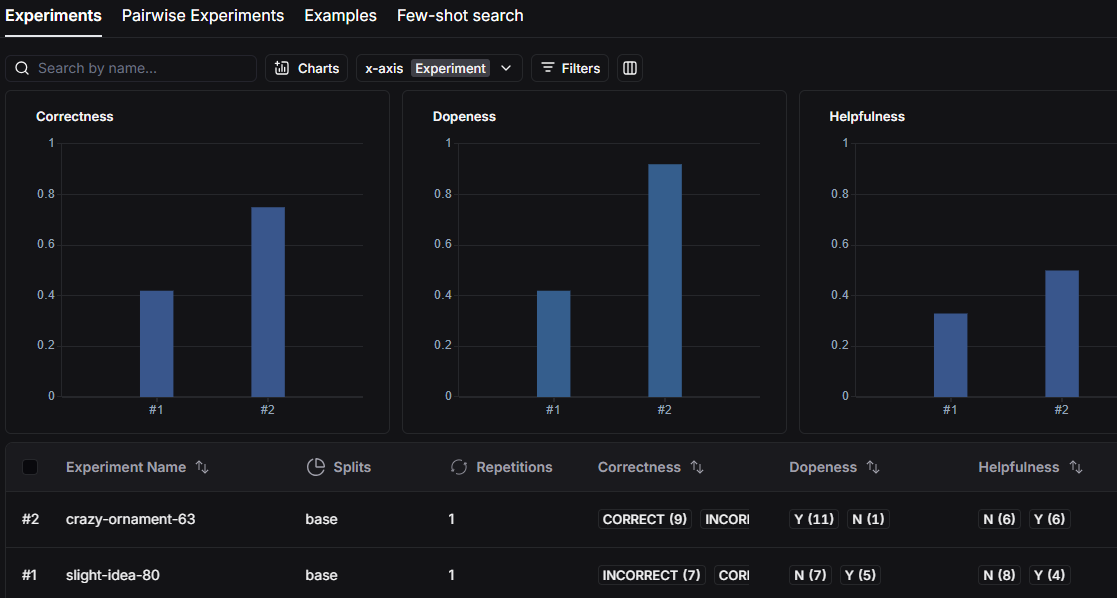